In [1]:
import os
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
# !pip install datasets
from datasets import load_dataset
import os



In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')


In [ ]:
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = ""
!kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.004
!kaggle competitions download -c diabetic-retinopathy-detection -f trainLabels.csv.zip

In [ ]:
! unzip "trainLabels.csv.zip"
! unzip "train.zip.004.zip"

In [ ]:
!apt install p7zip-full -y
!7z x train.zip.004
!ls train | wc -l #print number of images
!ls train

In [2]:
base_image_dir = "/home/workstation04/GP_LiverSegmentation_MeenaMakary/deeplearning/train"
retina_df = pd.read_csv("/home/workstation04/GP_LiverSegmentation_MeenaMakary/deeplearning/trainLabels.csv")
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(10)

8414 images found of 35126 total


2023-01-06 16:48:53.071118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 16:48:53.651873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-06 16:48:53.651923: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-06 16:48:53.651928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

,image,level,PatientId,path,exists,eye,level_cat
5512,6943_left,0,6943,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3264,4069_left,0,4069,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
34994,44199_left,3,44199,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[0.0, 0.0, 0.0, 1.0, 0.0]"
31792,40153_left,0,40153,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
5804,7315_left,0,7315,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
34835,44013_right,0,44013,/home/workstation04/GP_LiverSegmentation_Meena...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
33270,42020_left,1,42020,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"
5214,6555_left,0,6555,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
34436,43523_left,0,43523,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
32678,41263_left,0,41263,/home/workstation04/GP_LiverSegmentation_Meena...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


In [4]:

def balance_data(class_size,df): # a function to balance our data
    balanced_data_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    balanced_data_df = balanced_data_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', balanced_data_df.shape[0], 'Old Size:', df.shape[0])
    balanced_data_df['level'].hist(figsize = (10, 5))
    return balanced_data_df

In [3]:
retina_df.pivot_table(index='level', aggfunc=len) # old unbalanced data


,PatientId,exists,eye,image,level_cat,path
level,,,,,,
0,6182,6182,6182,6182,6182,6182
1,623,623,623,623,623,623
2,1282,1282,1282,1282,1282,1282
3,177,177,177,177,177,177
4,150,150,150,150,150,150


<AxesSubplot:>

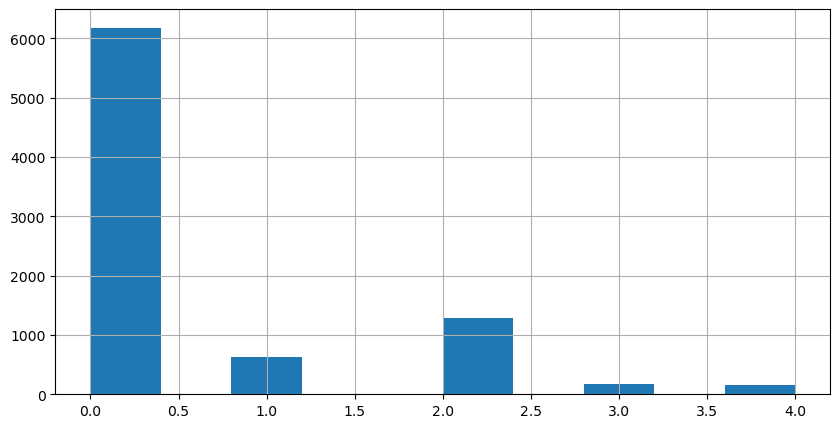

In [5]:
retina_df['level'].hist(figsize = (10, 5))

New Data Size: 750 Old Size: 8414


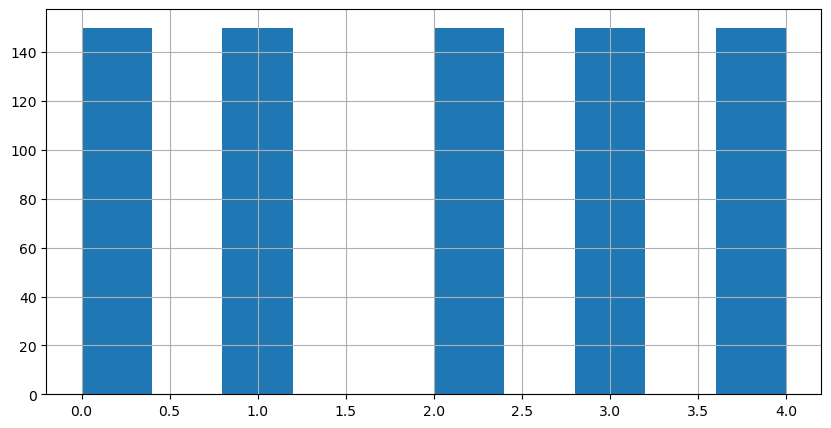

In [11]:
balanced_retina_df = balance_data(retina_df.pivot_table(index='level', aggfunc=len).min().min(),retina_df)  # balance with class_size = minimum class value to avoid duplicatation of the data


In [12]:
balanced_retina_df.pivot_table(index='level', aggfunc=len) # new balanced data


,PatientId,exists,eye,image,level_cat,path
level,,,,,,
0,150,150,150,150,150,150
1,150,150,150,150,150,150
2,150,150,150,150,150,150
3,150,150,150,150,150,150
4,150,150,150,150,150,150


In [ ]:
## saving balanced data on device for general use
def get_label_and_image(path):
  name= path.split('/')[-1].split('.')[0]

  label=balanced_retina_df["level"].loc[balanced_retina_df['image'] == name].values[0]
  image=Image.open(path)
  return image,label


train_ds={"image":[],
            "label":[]}

paths=balanced_retina_df["path"]
for path in paths:
  image,label=get_label_and_image(path)
  train_ds["image"].append(image)
  train_ds["label"].append(label)
from datasets import Dataset
dataset = Dataset.from_dict(train_ds)
dataset.save_to_disk("/home/workstation04/GP_LiverSegmentation_MeenaMakary/deeplearning/model_data")



In [ ]:
# writing balanced data on drive each class in its directory
import shutil

dataset_path="/content/drive/MyDrive/Diabetic Retinopathy Detection/Dataset/"
folders= ['No DR', 'Mild','Moderate','Severe','Proliferative']
for i in range(len(balanced_retina_df["level_cat"])):
  image=balanced_retina_df['path'][i]
  label=balanced_retina_df['level'][i]
  folder=folders[label]
  image_path=dataset_path+folder+f"/{i}_{label}.jpeg"
  shutil.copyfile(image, image_path)